# Lucerne and Pasture data cleaning
Soil water holding capacity is highly variable across short distances in alluvial soils such as the soil this trial was conducted on.  Replication helps to account for this variability but often there will still be differences in the mean absolute water content of treatments due to background soil variability and not due to the treatments them selves.  This creates difficulties for model optimisation where apparent model biases are actually due to this background variability.  To overcome this problem we conducted a bias analysis and correction in the observed data.  

What follows is anoted python code used to collate and graph the results from this analysis that is executable in a Jupyter notebook and may be used to reproduce this analysis if the data files are requested.

In [1]:
# Bring in the libraries we need
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.ticker as ticker
import GraphHelpers as GH
%matplotlib inline

In [2]:
# Bring in the cleaned observed data
TDRData = pd.read_pickle('.\DataFrames\LandPDailyTDR.pkl')
TDRData.index = TDRData.index.normalize()
NPData = pd.read_pickle('.\DataFrames\\NeutronProbeVWC_df.pkl')

#Stick the data together into a single dataframe
Data = NPData.join(TDRData)

In [3]:
GPs = GH.SetGraphicsPatterns(Data.D7.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['red','blue','orange','green'])

Species
['Lucerne', 'Ryegrass']
Irrigation
['Dry', 'High', 'Low', 'Mid']
Treatments
MultiIndex(levels=[['Lucerne', 'Ryegrass'], ['Dry', 'High', 'Low', 'Mid']],
           labels=[[0, 0, 0, 0, 1, 1, 1, 1], [0, 1, 2, 3, 0, 1, 2, 3]])
Styles
[('-', 'red', 0.15, 'o'), ('-', 'blue', 0.15, 'o'), ('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('--', 'red', 0.45, '^'), ('--', 'blue', 0.45, '^'), ('--', 'orange', 0.45, '^'), ('--', 'green', 0.45, '^')]
StyleFrame
              Lin     Col   Alp Mar     MFC
Lucerne  Dry    -     red  0.15   o     red
         High   -    blue  0.15   o    blue
         Low    -  orange  0.15   o  orange
         Mid    -   green  0.15   o   green
Ryegrass Dry   --     red  0.45   ^   white
         High  --    blue  0.45   ^   white
         Low   --  orange  0.45   ^   white
         Mid   --   green  0.45   ^   white


## First of all graph data to check we have what we expect

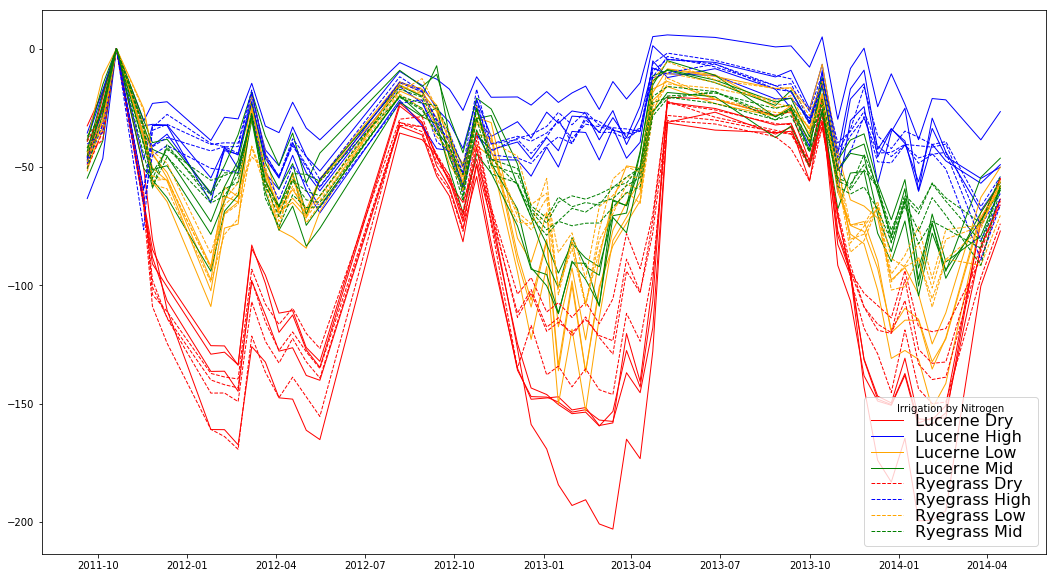

In [4]:
#Calculate the water content of the soil profile by multiplying the volumetric water content 
#by each layers depth and summing.  
ProfileWater = Data.loc[:,'D7'] * 150 + \
               Data.loc[:,'D23'] * 100 + \
               Data.loc[:,'D30'] * 100 + \
               Data.loc[:,'D50'] * 200 + \
               Data.loc[:,'D70'] * 200 + \
               Data.loc[:,'D90'] * 200 + \
               Data.loc[:,'D110'] * 200 + \
               Data.loc[:,'D130'] * 200 + \
               Data.loc[:,'D150'] * 200

                #Do some things to get the index tidy
ProfileWater.index = ProfileWater.index.normalize() # Need this step to remove hour values from dates
ProfileWater = ProfileWater.dropna(axis=0)      # This step removes all the dates where there were no measurements and nan were given

#Take field capacity as the water content on the 20th of October 2011
FieldCapacity = ProfileWater.loc['2011-10-20']   #Slicing a single date out of a data frame with date only format returns a multi indexed serise

#Calculate soil water deficit
SoilWaterDeficit = -(FieldCapacity - ProfileWater)  #This only works becaue FieldCapacity is a serise, not a dataframe
#and graph it
Fig = plt.figure(figsize=(18, 10))
ax = Fig.add_subplot(1,1,1)
GH.AddIndexedPlot(SoilWaterDeficit.loc[:,:],ax,GPs,1)
labels, handles = GH.DedupLegendElements()
ledg = plt.legend(labels, handles,loc=4,numpoints=1,fontsize = 16,labelspacing = 0.05, 
                          title='Irrigation by Nitrogen')

In [5]:
Irrigations = pd.read_excel('.\RawDataFiles\Irrigation.xlsx')
Irrigations.set_index(['Date'],inplace=True)
Irrigations = Irrigations.pivot(columns='Irrigation')
Irrigations.index = pd.to_datetime(Irrigations.index)
Irrigations.columns = Irrigations.columns.droplevel(0)
MetData = pd.read_pickle('.\DataFrames\BroadFieldsDaily.pkl').loc['2011-03-10':'2014-04-30',:]
Irrigations = Irrigations.reindex(MetData.index)
Irrigations.fillna(0,inplace=True)

In [6]:
ColIndex = pd.MultiIndex.from_product([('Ryegrass','Lucerne'),('Dry','Low','Mid','High'),('1','2','3','4')],names=['Species','Irrigation','Block'])
WaterUseNP = pd.DataFrame(index = pd.to_datetime(ProfileWater.index),
    columns = ColIndex)
WaterUseNPTotal = pd.DataFrame(index = pd.to_datetime(ProfileWater.index),
    columns = ColIndex)
WaterUseNP.loc[:,:]=0
DeltaSWCFrame = WaterUseNP.copy()
IrrigationFrame = WaterUseNP.copy()
RainFallFrame = WaterUseNP.copy()
for plot in WaterUseNP.columns:
    for P in WaterUseNP.index:
        if P.strftime('%Y-%m-%d') == '2011-09-20':
            PrevPSWC = ProfileWater.loc[P.strftime('%Y-%m-%d'),plot]
            PrevMeasureDate = '2011-09-20'
        else:
            #print(P.strftime('%Y-%m-%d'))
            DeltaSWC = PrevPSWC - ProfileWater.loc[P.strftime('%Y-%m-%d'),plot]
            #print(DeltaSWC)
            DeltaSWCFrame.loc[P.strftime('%Y-%m-%d'),plot] = DeltaSWC
            Irrigation = Irrigations.loc[PrevMeasureDate:P.strftime('%Y-%m-%d'),plot[1]].sum()
            IrrigationFrame.loc[P.strftime('%Y-%m-%d'),plot] = Irrigation
            #print(Irrigation)
            Rainfall = MetData.loc[PrevMeasureDate:P.strftime('%Y-%m-%d'),'Rainfall'].sum()
            RainFallFrame.loc[P.strftime('%Y-%m-%d'),plot] = Rainfall
            #print(Rainfall)
            WU = DeltaSWC + Irrigation + Rainfall 
            #print(WU)
            duration = (P - datetime.datetime.strptime(PrevMeasureDate,'%Y-%m-%d')).days
            WaterUseNP.loc[P.strftime('%Y-%m-%d'),plot] = WU/duration
            WaterUseNPTotal.loc[P.strftime('%Y-%m-%d'),plot] = WU
            PrevPSWC = ProfileWater.loc[P.strftime('%Y-%m-%d'),plot]
            PrevMeasureDate = P.strftime('%Y-%m-%d')

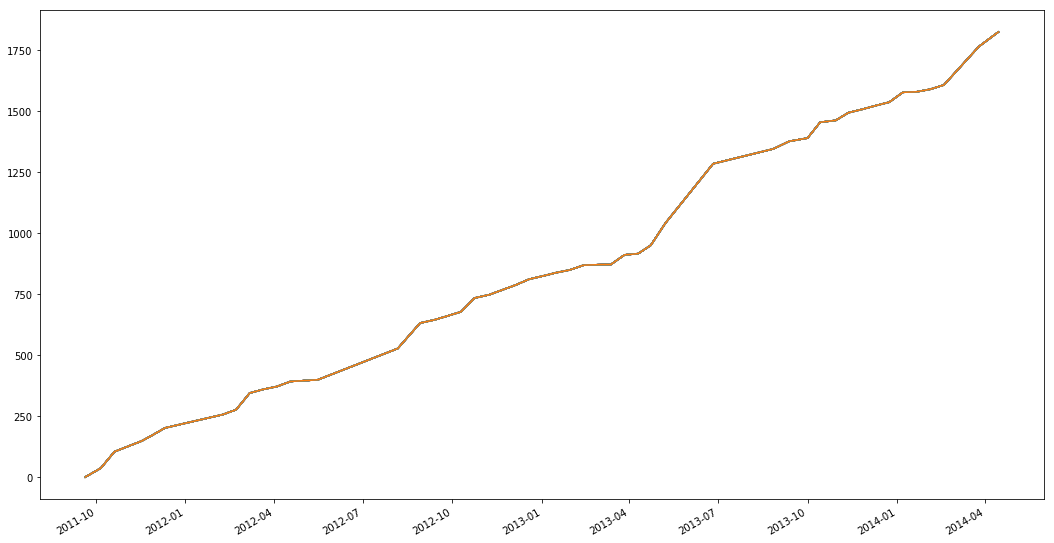

In [7]:
RainFallFrame.cumsum().plot(legend=False,figsize=(18, 10))

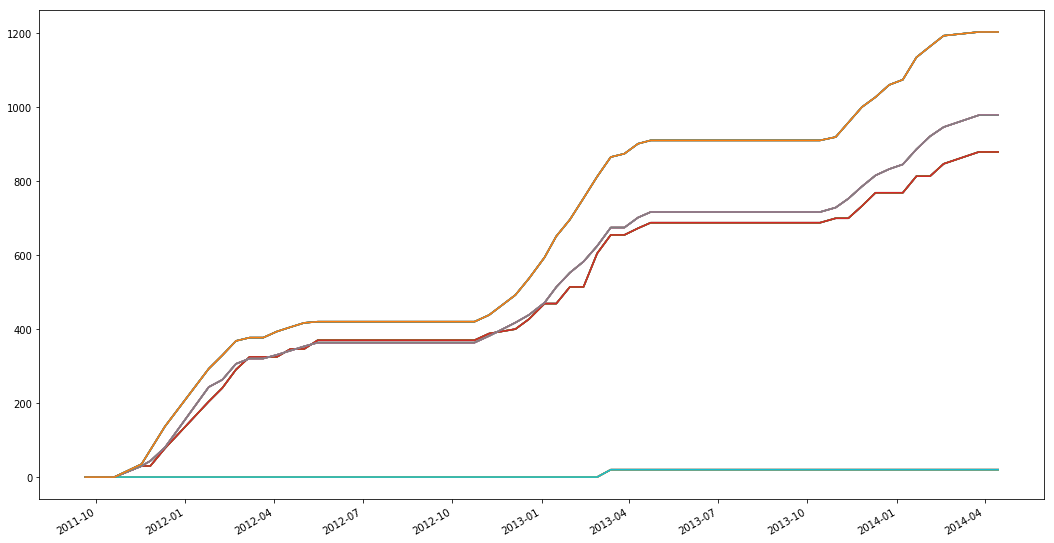

In [8]:
IrrigationFrame.cumsum().plot(legend=False,figsize=(18, 10))

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


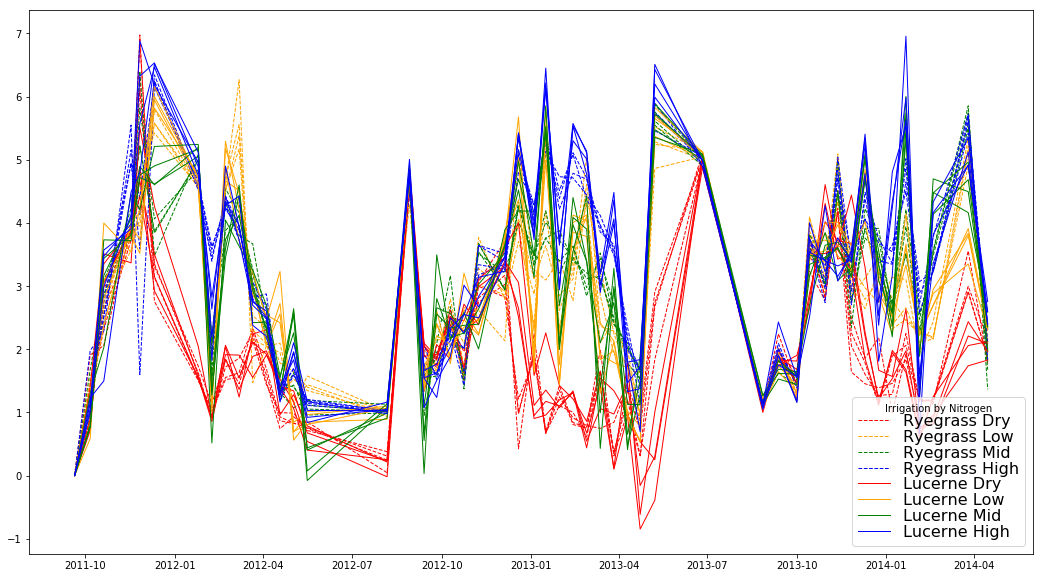

In [9]:
Fig = plt.figure(figsize=(18, 10))
ax = Fig.add_subplot(1,1,1)
GH.AddIndexedPlot(WaterUseNP,ax,GPs,1)
labels, handles = GH.DedupLegendElements()
ledg = plt.legend(labels, handles,loc=4,numpoints=1,fontsize = 16,labelspacing = 0.05, 
                          title='Irrigation by Nitrogen')

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


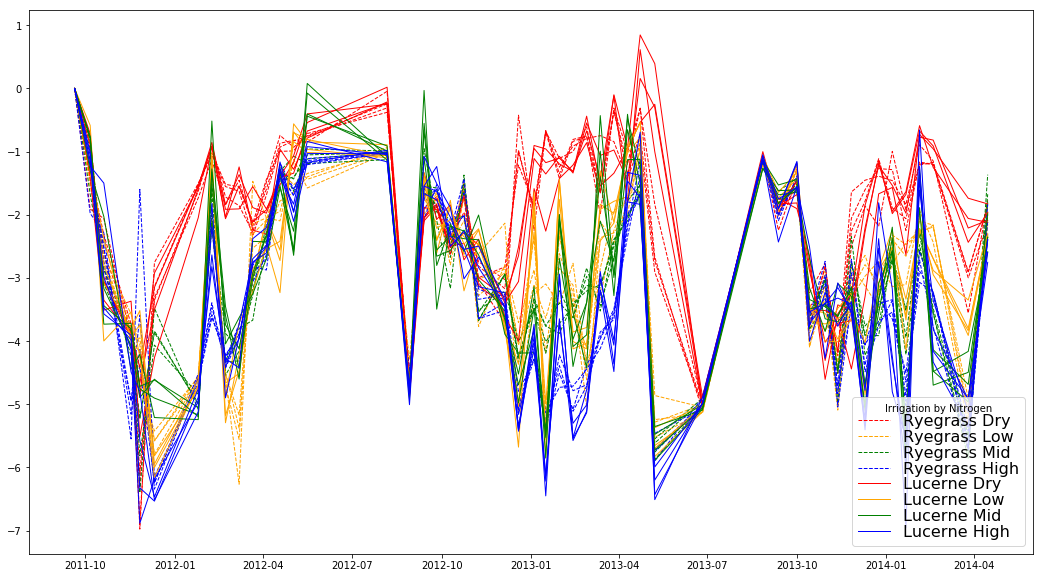

In [10]:
Fig = plt.figure(figsize=(18, 10))
ax = Fig.add_subplot(1,1,1)
GH.AddIndexedPlot(-WaterUseNP.loc[:,:],ax,GPs,1)
labels, handles = GH.DedupLegendElements()
ledg = plt.legend(labels, handles,loc=4,numpoints=1,fontsize = 16,labelspacing = 0.05, 
                          title='Irrigation by Nitrogen')

In [11]:
SpecLab = WaterUseNP.columns.get_level_values(0)
IrriLab = WaterUseNP.columns.get_level_values(1)
BlocLab = WaterUseNP.columns.get_level_values(2)
NewCols = pd.MultiIndex.from_arrays([SpecLab,
                                     SpecLab,
                                     IrriLab,
                                     SpecLab,
                                     BlocLab], names=['Species','Crop','Irrigation','Nitrogen','Block'])
WaterUseNP.columns = NewCols
WaterUseNPTotal.columns = NewCols

In [12]:
WaterUseNP.Ryegrass

Crop        Ryegrass                                                    \
Irrigation       Dry                                     Low             
Nitrogen    Ryegrass                                Ryegrass             
Block              1         2         3         4         1         2   
2011-09-20  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2011-10-06  1.456250  1.294476  1.909375  1.406250  0.865625  1.550000   
2011-10-20  2.953571  2.318943  2.059879  2.596429  2.735714  2.428571   
2011-11-17  3.827354  3.728119  3.948632  3.790362  3.944643  3.808929   
2011-11-26  6.309343  6.976204  6.844444  6.096651  4.455556  4.694444   
2011-12-11  3.136667  2.756667  3.313333  3.353333  5.580000  5.423333   
2012-01-25  1.512222  1.505556  1.734444  1.628889  4.611369  4.572145   
2012-02-08  1.057143  1.021429  1.132143  0.910714  2.106312  1.468106   
2012-02-22  1.553571  1.517857  1.842857  1.717857  4.525000  4.492857   
2012-03-07  1.628571  1.558890  1.452822  1.857143  5.169945  5.377296   
2012-03-21  2.335714  2.139347  2.175750  2.278571  2.305055  2.529847   
2012-04-04  1.689286  1.441049  1.596429  1.485714  2.085714  2.346429   
2012-04-18  0.928571  0.996429  0.867857  0.742857  1.300000  1.782143   
2012-05-02  0.828571  0.989286  0.821429  0.932143  1.525000  1.650000   
2012-05-16  0.760714  0.714286  0.850000  0.750000  1.346429  1.400000   
2012-08-06  0.308281  0.378659  0.045122  0.244512  0.997561  0.935366   
2012-08-29  4.557433  4.493478  4.710870  4.613043  4.671739  4.632609   
2012-09-13  1.676667  2.043333  2.050000  1.886667  1.373333  1.993333   
2012-09-26  1.877620  1.756997  1.729145  1.712518  1.850000  1.653846   
2012-10-10  2.535068  2.389932  2.505080  2.391947  2.792857  2.471429   
2012-10-24  1.676361  1.602026  1.495227  1.960634  1.728571  2.096429   
2012-11-08  2.811832  2.996202  3.071493  2.743212  3.770448  3.018546   
2012-12-05  3.170721  2.825529  3.710830  3.026390  2.792667  2.860113   
2012-12-19  0.977089  1.213273  0.423737  1.005942  3.707503  3.999911   
2013-01-04  1.950922  1.845136  2.247735  1.931702  2.871015  2.362500   
2013-01-16  0.679167  0.673445  0.691133  0.666667  4.175000  5.100000   
2013-01-30  1.107143  1.246429  1.425882  1.353571  2.616039  2.334046   
2013-02-13  0.999932  0.913968  0.838829  0.807582  3.233961  3.405750   
2013-02-27  0.608571  0.792557  0.762007  0.750860  5.046429  4.303061   
2013-03-13  1.656428  0.747507  1.645593  1.998700  2.364286  2.103173   
2013-03-27  0.351429  0.842379  0.362536  0.310293  2.285714  2.446878   
2013-04-10  1.351497  1.419947  1.201750  1.011136  1.992857  1.807092   
2013-04-23  0.719231  0.882384  0.319231  0.311538  0.924991  0.805348   
2013-05-08  2.731937  2.906667  1.836667  2.670000  4.861675  5.522031   
2013-06-26  5.007570  5.024490  4.996939  5.104082  5.046939  5.123469   
2013-08-27  1.065469  1.077419  1.070161  1.072581  1.127419  1.042742   
2013-09-12  1.980684  1.953125  2.243750  2.018750  2.015625  1.915625   
2013-10-01  1.444737  1.581579  1.421053  1.276316  1.165789  1.318421   
2013-10-14  3.673077  3.461538  3.234615  3.780769  4.080769  3.869231   
2013-10-30  2.831250  3.134375  2.771875  2.815625  3.250000  3.334375   
2013-11-12  4.230769  4.176923  4.511538  4.180769  4.896154  5.092308   
2013-11-26  2.053571  1.639286  2.500000  2.257143  2.992857  2.835606   
2013-12-10  1.603571  1.453571  1.860714  1.785714  2.642857  3.125183   
2013-12-24  1.269242  1.388789  2.182054  1.112491  3.271429  3.471354   
2014-01-07  1.285685  1.459629  0.996517  1.891080  2.389286  2.780205   
2014-01-21  2.248644  1.838718  1.921429  2.061136  2.657143  2.441224   
2014-02-04  1.165585  0.891435  1.185714  1.211559  2.105139  2.257968   
2014-02-18  1.202273  1.148030  1.200000  1.170900  2.162718  2.196161   
2014-03-26  2.998611  3.556322  2.916667  2.898324  5.111148  4.912283   
2014-04-15  2.147500  1.772500  1.848591  1.875000  2.152433  1.961652   

Cro

In [13]:
(WaterUseNP.Lucerne*-1).to_pickle('.\DataFrames\LucDailyWU.pkl')
(WaterUseNP.Ryegrass*-1).to_pickle('.\DataFrames\RyeDailyWU.pkl')
WaterUseNPTotal.Lucerne.to_pickle('.\DataFrames\LucWU.pkl')
WaterUseNPTotal.Ryegrass.to_pickle('.\DataFrames\RyeWU.pkl')

In [14]:
WaterUseNPTotal

Species    Ryegrass                                                        \
Crop       Ryegrass                                                         
Irrigation      Dry                                 Low                     
Nitrogen   Ryegrass                            Ryegrass                     
Block             1        2        3        4        1        2        3   
2011-09-20      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2011-10-06     23.3  20.7116    30.55     22.5    13.85     24.8    18.85   
2011-10-20    41.35  32.4652  28.8383    36.35     38.3       34     37.2   
2011-11-17  107.166  104.387  110.562   106.13   110.45   106.65    111.5   
2011-11-26  56.7841  62.7858     61.6  54.8699     40.1    42.25    35.55   
2011-12-11    47.05    41.35     49.7     50.3     83.7    81.35    83.65   
2012-01-25    68.05    67.75    78.05     73.3  207.512  205.747  204.903   
2012-02-08     14.8     14.3    15.85    12.75  29.4884  20.5535  27.0973   
2012-02-22    21.75    21.25     25.8    24.05    63.35     62.9     65.9   
2012-03-07     22.8  21.8245  20.3395       26  72.3792  75.2821  77.7625   
2012-03-21     32.7  29.9509  30.4605     31.9  32.2708  35.4179  29.9875   
2012-04-04    23.65  20.1747    22.35     20.8     29.2    32.85     28.7   
2012-04-18       13    13.95    12.15     10.4     18.2    24.95    27.25   
2012-05-02     11.6    13.85     11.5    13.05    21.35     23.1    16.35   
2012-05-16    10.65       10     11.9     10.5    18.85     19.6    20.15   
2012-08-06   25.279    31.05      3.7    20.05     81.8     76.7    83.15   
2012-08-29  104.821   103.35   108.35    106.1   107.45   106.55    110.4   
2012-09-13    25.15    30.65    30.75     28.3     20.6     29.9    25.35   
2012-09-26  24.4091   22.841  22.4789  22.2627    24.05     21.5     21.5   
2012-10-10  35.4909   33.459  35.0711  33.4873     39.1     34.6    34.45   
2012-10-24  23.4691  22.4284  20.9332  27.4489     24.2    29.35     21.8   
2012-11-08  42.1775   44.943  46.0724  41.1482  56.5567  45.2782     49.2   
2012-12-05  85.6095  76.2893  100.192  81.7125   75.402  77.2231  78.6489   
2012-12-19  13.6792  16.9858  5.93232  14.0832   51.905  55.9987  56.9309   
2013-01-04  31.2148  29.5222  35.9638  30.9072  45.9362     37.8  49.6516   
2013-01-16     8.15  8.08134  8.29359        8     50.1     61.2  43.6732   
2013-01-30     15.5    17.45  19.9623    18.95  36.6245  32.6766   39.864   
2013-02-13   13.999  12.7956  11.7436  11.3061  45.2755  47.6805  43.5938   
2013-02-27     8.52  11.0958  10.6681   10.512    70.65  60.2429  64.5875   
2013-03-13    23.19  10.4651  23.0383  27.9818     33.1  29.4444     39.9   
2013-03-27  4.92001  11.7933   5.0755   4.3441       32  34.2563       27   
2013-04-10   18.921  19.8793  16.8245  14.1559     27.9  25.2993  25.0683   
2013-04-23     9.35   11.471     4.15     4.05  12.0249  10.4695  14.4317   
2013-05-08  40.9791     43.6    27.55    40.05  72.9251  82.8305    78.65   
2013-06-26  245.371    246.2   244.85    250.1    247.3   251.05      252   
2013-08-27  66.0591     66.8    66.35     66.5     69.9    64.65    66.85   
2013-09-12  31.6909    31.25     35.9     32.3    32.25    30.65    30.95   
2013-10-01    27.45    30.05       27    24.25    22.15    25.05    24.65   
2013-10-14    47.75       45    42.05    49.15    53.05     50.3  49.6239   
2013-10-30     45.3    50.15    44.35    45.05       52    53.35  50.3261   
2013-11-12       55     54.3    58.65    54.35    63.65     66.2     58.2   
2013-11-26    28.75    22.95       35     31.6     41.9  39.6985  44.6975   
2013-12-10    22.45    20.35    26.05       25       37  43.7526  39.0525   
2013-12-24  17.7694  19.4431  30.5488  15.5749     45.8   48.599     43.2   
2014-01-07  17.9996  20.4348  13.9512  26.4751    33.45  38.9229     32.5   
2014-01-21   31.481  25.7421     26.9  28.8559     37.2  34.1771     34.6   
2014-02-04  16.3182  12.4801     16.6  16.9618  29.4719  31.6115  32.2509

In [15]:
Data

Depth           D110                                                  \
Species      Lucerne                                                   
Irrigation       Dry                                  High             
Block              1       2         3         4         1         2   
2011-06-09  0.094000  0.1160  0.098000  0.101000  0.112000  0.120000   
2011-09-20  0.090000  0.1130  0.094000  0.100000  0.110000  0.112000   
2011-10-06  0.086000  0.1090  0.105000  0.092000  0.104000  0.107000   
2011-10-20  0.106000  0.1350  0.114000  0.116000  0.117000  0.132000   
2011-11-17  0.091000  0.1120  0.094000  0.095000  0.107000  0.115000   
2011-11-26  0.087500  0.1055  0.091000  0.097500  0.113500  0.130500   
2011-12-11  0.080000  0.1030  0.091000  0.096000  0.114000  0.124000   
2012-01-25  0.068751  0.0900  0.078000  0.078501  0.104000  0.113000   
2012-02-08  0.067405  0.0880  0.077000  0.076972  0.106000  0.122000   
2012-02-22  0.054000  0.0760  0.069000  0.070343  0.107000  0.116000   
2012-03-07  0.069872  0.1030  0.074000  0.079776  0.115000  0.127000   
2012-03-21  0.069423  0.1030  0.072000  0.079266  0.111000  0.114000   
2012-04-04  0.065163  0.0940  0.069000  0.074422  0.109000  0.106000   
2012-04-18  0.056000  0.0830  0.069000  0.070598  0.105000  0.114000   
2012-05-02  0.056000  0.0800  0.064000  0.070000  0.101000  0.104000   
2012-05-16  0.055000  0.0750  0.066000  0.064000  0.103000  0.097000   
2012-08-06  0.096000  0.1280  0.100000  0.106000  0.117000  0.125000   
2012-08-29  0.092000  0.1240  0.097000  0.102000  0.114000  0.121000   
2012-09-13  0.086000  0.1170  0.091000  0.097000  0.112000  0.117000   
2012-09-26  0.085000  0.1060  0.089000  0.091000  0.105000  0.113000   
2012-10-10  0.079000  0.1040  0.086000  0.088000  0.102000  0.107000   
2012-10-24  0.075000  0.1060  0.085000  0.085000  0.110000  0.114000   
2012-11-08  0.075000  0.1070  0.081000  0.086000  0.109000  0.110000   
2012-11-21  0.070000  0.1000  0.081000  0.078000  0.108000  0.124000   
2012-12-05  0.056000  0.0720  0.069000  0.060000  0.104000  0.108384   
2012-12-19  0.054000  0.0630  0.067000  0.054000  0.098000  0.105000   
2013-01-04  0.054000  0.0630  0.065000  0.055000  0.114650  0.121000   
2013-01-16  0.051000  0.0610  0.061000  0.056000  0.090000  0.096000   
2013-01-30  0.049000  0.0600  0.060000  0.054000  0.114082  0.130000   
2013-02-13  0.051000  0.0600  0.062000  0.054000  0.108000  0.123000   
2013-02-27  0.056000  0.0580  0.060000  0.055000  0.101000  0.121000   
2013-03-13  0.052000  0.0600  0.057000  0.052000  0.112000  0.129000   
2013-03-27  0.050000  0.0590  0.058000  0.055000  0.107000  0.115000   
2013-04-10  0.052000  0.0590  0.060000  0.054000  0.110000  0.127000   
2013-04-23  0.054000  0.0640  0.061000  0.055000  0.117000  0.129000   
2013-05-08  0.097000  0.1270  0.105000  0.104000  0.115000  0.129000   
2013-06-26  0.095000  0.1230  0.098000  0.104000  0.116000  0.128000   
2013-08-27  0.093000  0.1250  0.097000  0.102000  0.113000  0.123000   
2013-09-12  0.095000  0.1250  0.098000  0.099000  0.116000  0.128000   
2013-10-01  0.084000  0.1090  0.091000  0.094000  0.106000  0.117000   
2013-10-14  0.095000  0.1240  0.100000  0.106000  0.113000  0.127000   
2013-10-30  0.076000  0.1090  0.089000  0.096000  0.109000  0.114000   
2013-11-12  0.073000  0.1050  0.091000  0.091000  0.119000  0.136000   
2013-11-26  0.055000  0.0690  0.069000  0.060000  0.114000  0.130000   
2013-12-10  0.052000  0.0610  0.063492  0.054000  0.107000  0.108000   
2013-12-24  0.053000  0.0620  0.060000  0.055000  0.113000  0.121340   
2014-01-07  0.052000  0.0610  0.063000  0.055000  0.112000  0.127000   
2014-01-21  0.047000  0.0630  0.061000  0.053000  0.100000  0.110000   
2014-02-04  0.049000  0.0620  0.062000  0.050000  0.110000  0.128000   
2014-02-18  0.053000  0.0610  0.060000  0.053000  0.109000  0.117000   
2014-03-26  0.066000  0.0860  0.064000  0.073000  0.085000  0.090000   
2014-04-15  0.077000  0.1020  0.079000  

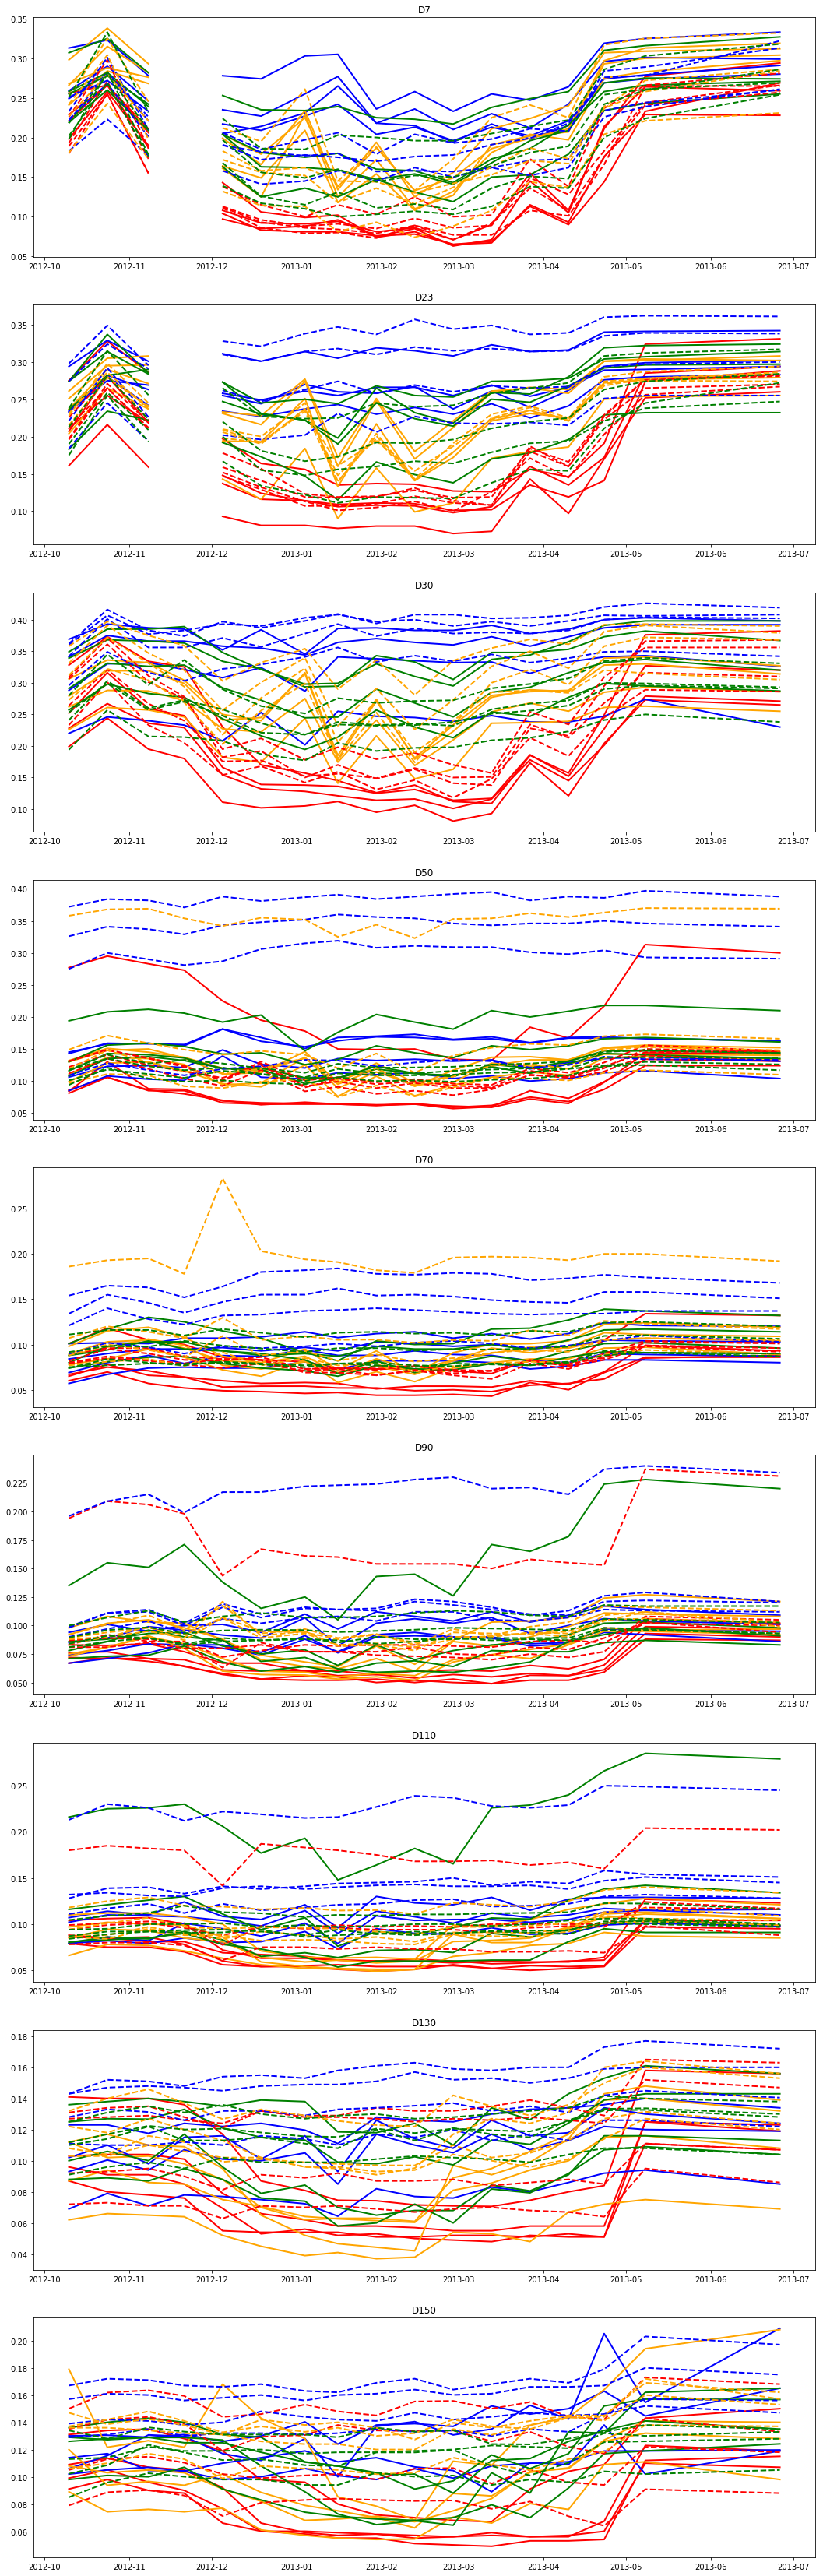

In [16]:
Fig = plt.figure(figsize=(18, 60))
pos=1
for D in ['D7','D23','D30', 'D50', 'D70', 'D90','D110', 'D130', 'D150']:
    ax = Fig.add_subplot(9,1,pos)
    GH.AddIndexedPlot(Data.loc['2012-10-01':'2013-07-01',D],ax,GPs,2)
    plt.title(D)
    pos+=1